# Comparaison de performances sur un cas de recherche de mot unique dans un signal

## Paramétrage et créations du mot unique et du signal

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numba
from numba import jit, njit, prange, complex128, float64, int64
from numba import cuda
import cupy as cp

In [2]:
import os
os.environ['PYFFTW_NUM_THREADS'] = '-1' # use CPU count
import pyfftw

In [3]:
Fs = 1e6
f0 = -47e3
nrUW = 32
nrSamples = 2**20
nrDisplay = 2**14
snr = 10.0

In [4]:
np.random.seed(1973)

In [5]:
mapper_qpsk = lambda data: np.exp(1j * np.pi * (data/2 + 1/4))

In [6]:
dataUW = np.random.randint(4, size=(nrUW,))
symbolsUW = mapper_qpsk(dataUW)

In [7]:
dataAll = np.random.randint(4, size=(nrSamples,))
symbolsAll = mapper_qpsk(dataAll)

In [8]:
idxStartUW = np.random.randint(0, nrSamples - nrUW)
symbolsAll[idxStartUW:(idxStartUW + nrUW)] = symbolsUW[:]

In [9]:
sigma = 10**(-snr/20)
noise = np.random.normal(size=(nrSamples,)) + 1j * np.random.normal(size=(nrSamples,))
signalBaseband = symbolsAll + sigma * noise

In [10]:
def display_constellation(signal, color='r', title='Constellation'):
    plt.figure()
    plt.scatter(np.real(signal[:nrDisplay]), np.imag(signal[:nrDisplay]), s=30, c=color, alpha=0.1, edgecolors='none')
    plt.grid()
    plt.axis('equal')
    plt.xlabel('I')
    plt.ylabel('Q')
    plt.title(title)
    plt.show()

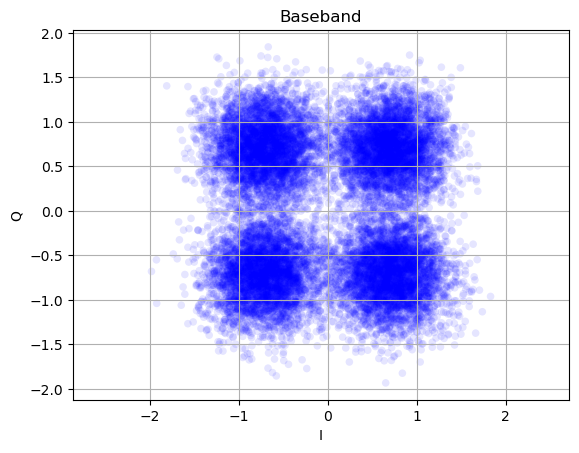

In [11]:
display_constellation(signalBaseband, 'b', 'Baseband')

### Génération d'un décalage en fréquence sur le signal
(juste pour test du gain apporté par Numba pour la génération de l'OL)

In [11]:
def create_ol(df, Fs, nr):
    phi = 0
    ol = np.empty((nr,), dtype=complex)
    for k in range(nr):
        ol[k] = np.exp(1j * phi)
        phi = np.mod(phi + 2 * np.pi * df / Fs, 2 * np.pi)
    return ol

In [16]:
%timeit ol = create_ol(f0, Fs, nrSamples)

1.33 s ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
ol = create_ol(f0, Fs, nrSamples)
signal = signalBaseband * ol

In [14]:
@njit(['complex128[:](float64,float64,int64)'])
def create_ol_jit(df, Fs, nr):
    phi = 0
    ol = np.empty((nr,), dtype=np.complex128)
    for k in range(nr):
        ol[k] = np.exp(1j * phi)
        phi = np.mod(phi + 2 * np.pi * df / Fs, 2 * np.pi)
    return ol

In [18]:
%timeit ol = create_ol_jit(f0, Fs, nrSamples)

16.3 ms ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
ol = create_ol_jit(f0, Fs, nrSamples)
signal = signalBaseband * ol

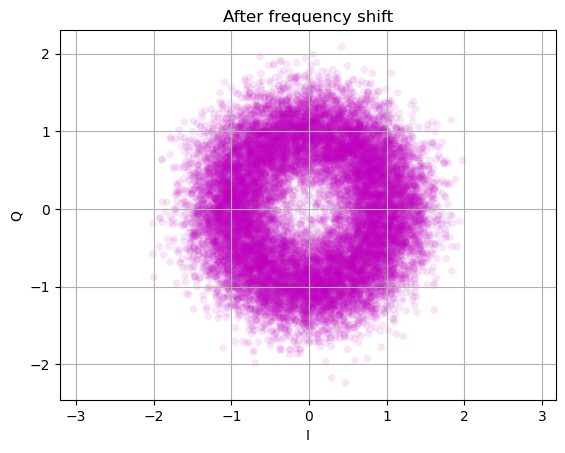

In [16]:
display_constellation(signal, 'm', 'After frequency shift')

## Recherche par méthode naïve en Python pur

In [17]:
def find_uw(s, uw):
    nr = len(s)
    nrUW = len(uw)
    cMax = 0
    idxMax = 0
    for k in range(nr - nrUW + 1):
        cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        if cAbs > cMax:
            cMax = cAbs
            idxMax = k
    return idxMax, cMax

In [24]:
%timeit idxFound, cMaxFound = find_uw(signalBaseband, symbolsUW)

3.29 s ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
idxFound, cMaxFound = find_uw(signalBaseband, symbolsUW)

In [19]:
print("position du motif trouvée à : ", idxFound)
print("position réelle du motif : ", idxStartUW)

position du motif trouvée à :  185443
position réelle du motif :  185443


In [20]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Numba

In [86]:
#@njit(['Tuple((int64,float64))(complex128[:],complex128[:])'])
@njit
def find_uw_jit(s, uw):
    nr = len(s)
    nrUW = len(uw)
    
    cMax = 0
    idxMax = 0
    
    for k in range(nr - nrUW + 1):
        cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        if cAbs > cMax:
            cMax = cAbs
            idxMax = k
    
    return idxMax, cMax

In [87]:
%timeit idxFound, cMaxFound = find_uw_jit(signalBaseband, symbolsUW)

87.6 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
idxFound, cMaxFound = find_uw_jit(signalBaseband, symbolsUW)

In [89]:
print("position du motif trouvée à : ", idxFound)

position du motif trouvée à :  185443


In [90]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Numba parallélisé

In [91]:
numba.get_num_threads()

16

In [92]:
#@njit(['Tuple((int64,float64))(complex128[:],complex128[:])'], parallel=True)
@njit(parallel=True)
def find_uw_jit_parallel(s, uw):
    nr = len(s)
    nrUW = len(uw)
    nrThreads = numba.get_num_threads()
    
    cMax = np.zeros(shape=(nrThreads,), dtype=np.float64)
    idxMax = np.zeros(shape=(nrThreads,), dtype=np.int64)
    
    for k in prange(nr - nrUW + 1):
        cAbs = np.abs(np.sum(s[k:k + nrUW] * np.conj(uw)))
        idThread = numba.get_thread_id()
        if cAbs > cMax[idThread]:
            cMax[idThread] = cAbs
            idxMax[idThread] = k
    
    idxMaxGlobal = np.argmax(cMax)
    
    return idxMax[idxMaxGlobal], cMax[idxMaxGlobal]

In [93]:
%timeit idxFound, cMaxFound = find_uw_jit_parallel(signalBaseband, symbolsUW)

7.89 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
idxFound, cMaxFound = find_uw_jit_parallel(signalBaseband, symbolsUW)

In [95]:
print("position du motif trouvée à : ", idxFound)

position du motif trouvée à :  185443


In [96]:
assert(idxFound == idxStartUW)

## Recherche utilisant le code naïf mais compilé par Numba pour Cuda (kernel)

In [42]:
@cuda.jit('void(complex128[:],complex128[:],float64[:])')
def find_uw_cuda_jit(s, uw, cAbs):
    nr = len(s)
    nrUW = len(uw)
    idx = cuda.grid(1)
    if idx < (nr - nrUW + 1):
        sUw = 0
        for k in range(nrUW):
            sUw += s[idx + k] * uw[k].conjugate()
        cAbs[idx] = abs(sUw)

In [49]:
%%timeit
sBbCu = cuda.to_device(signalBaseband)
uwCu = cuda.to_device(symbolsUW)
cAbsCu = cuda.device_array((nrSamples - nrUW + 1,), dtype=np.float64)
find_uw_cuda_jit.forall(len(cAbsCu))(sBbCu, uwCu, cAbsCu)
# switch to Cupy library to apply the argmax reduction
cAbsCp = cp.asarray(cAbsCu)
idxFoundCp = cp.argmax(cAbsCp)
cMaxFoundCp = cAbsCp[idxFoundCp]
idxFound = idxFoundCp.item()
cMaxFound = cMaxFoundCp.item()

4.11 ms ± 95.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
sBbCu = cuda.to_device(signalBaseband)
uwCu = cuda.to_device(symbolsUW)
cAbsCu = cuda.device_array((nrSamples - nrUW + 1,), dtype=np.float64)
find_uw_cuda_jit.forall(len(cAbsCu))(sBbCu, uwCu, cAbsCu)
# switch to Cupy library to apply the argmax reduction
cAbsCp = cp.asarray(cAbsCu)
idxFoundCp = cp.argmax(cAbsCp)
cMaxFoundCp = cAbsCp[idxFoundCp]
idxFound = idxFoundCp.item()
cMaxFound = cMaxFoundCp.item()

In [45]:
# to switch back to Numba Cuda
# xCu = cuda.as_cuda_array(cAbsCp)

In [46]:
idxFound

185443

## Recherche utilisant une corrélation globale utilisant la FFT de Numpy

In [25]:
def find_uw_fft(s, uw):
    nr = len(s)
    nrUW = len(uw)
    sF = np.fft.fft(s)
    uwL = np.zeros_like(sF)
    uwL[:nrUW] = uw
    uwLF = np.fft.fft(uwL)
    cAbs = np.abs(np.fft.ifft(sF * np.conj(uwLF)))
    idxMax = np.argmax(cAbs)
    cMax = cAbs[idxMax]
    return idxMax, cMax

In [37]:
%timeit idxFound, cMaxFound = find_uw_fft(signalBaseband, symbolsUW)

87 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
idxFound, cMaxFound = find_uw_fft(signalBaseband, symbolsUW)

In [27]:
print("position du motif trouvée par FFT à : ", idxFound)

position du motif trouvée par FFT à :  185443


In [28]:
assert(idxFound == idxStartUW)

## Recherche utilisant une corrélation globale utilisant la FFT de pyFFTW

In [12]:
pyfftw.config.NUM_THREADS

16

In [13]:
def find_uw_fftw(s, uw):
    nr = len(s)
    nrUW = len(uw)
    sFFTW = pyfftw.empty_aligned((nrSamples,), dtype=np.complex128)
    sFFTW[:] = s
    uwLFFTW = pyfftw.zeros_aligned((nrSamples,), dtype=np.complex128)
    uwLFFTW[:nrUW] = uw
    sF = pyfftw.interfaces.numpy_fft.fft(sFFTW)
    uwLF = pyfftw.interfaces.numpy_fft.fft(uwLFFTW)
    cAbs = np.abs(pyfftw.interfaces.numpy_fft.ifft(sF * np.conj(uwLF)))
    idxMax = np.argmax(cAbs)
    cMax = cAbs[idxMax]
    return idxMax, cMax

In [15]:
%timeit idxFound, cMaxFound = find_uw_fftw(signalBaseband, symbolsUW)

50.6 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
idxFound, cMaxFound = find_uw_fftw(signalBaseband, symbolsUW)

In [17]:
print("position du motif trouvée par FFT à : ", idxFound)

position du motif trouvée par FFT à :  185443


In [18]:
assert(idxFound == idxStartUW)

## Recherche utilisant une corrélation globale par FFT sur GPU à l'aide de Cupy

In [19]:
def find_uw_fft_gpu(s, uw):
    nr = len(s)
    nrUW = len(uw)
    sGpu = cp.asarray(s)
    sF = cp.fft.fft(sGpu)
    uwLGpu = cp.zeros_like(sF)
    uwLGpu[:nrUW] = cp.asarray(uw)
    uwLF = cp.fft.fft(uwLGpu)
    cAbs = cp.abs(cp.fft.ifft(sF * cp.conj(uwLF)))
    idxMax = cp.argmax(cAbs)
    cMax = cAbs[idxMax]
    return idxMax.item(), cMax.item()

In [20]:
%timeit idxFound, cMaxFound = find_uw_fft_gpu(signalBaseband, symbolsUW)

5.05 ms ± 6.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
idxFound, cMaxFound = find_uw_fft_gpu(signalBaseband, symbolsUW)

In [22]:
assert(idxFound == idxStartUW)